# KF with data - SIR -> SIRM

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 12

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Tue May 12 12:02:16 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
fontsize=14
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }
plt.rcParams["font.size"     ] = fontsize

def figure(size = (10, 8)):
    plt.figure(figsize = size)

In [5]:
import c19.basic_models as cbm

from c19.types import SIR, SIR2

from scipy.integrate import odeint
#import scipy.integrate as spi
#from scipy.interpolate import interp1d

In [8]:
import c19.useir            as us
import c19.kfmysir          as kf
import c19.mydata_functions as mdf

import scipy          as sp
import scipy.stats    as stats
import scipy.optimize as optimize

from numpy.linalg import inv
mprod_ = np.matmul
npa    = np.array

### Generate USEIR

fpois


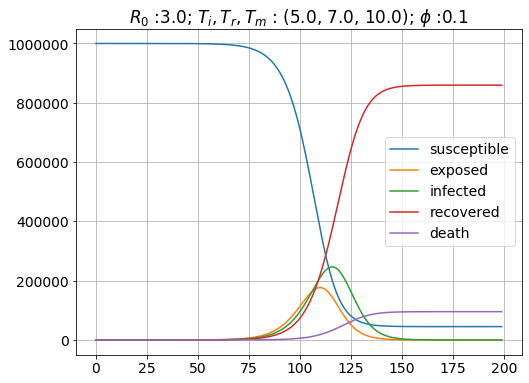

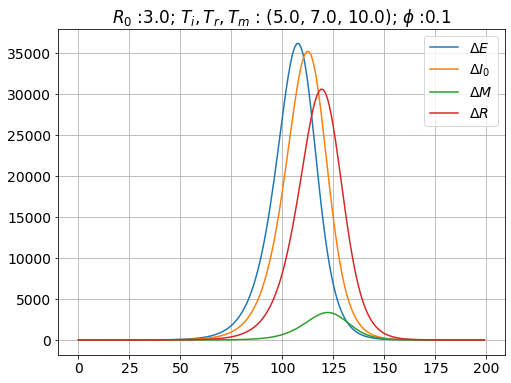

In [9]:
N               = 1e6
R0, TI, TR, TM  = 3., 5., 7., 10.
PhiM            = 0.1
ndays           = 200
rho             = 'poisson'
frho            = us.frho(rho)
ts = np.arange(ndays)
SS, DD          = us.uSEIR(N, R0, TI, TR, TM, PhiM, ndays, rho = rho)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

title = r'$R_0$ :'+ str(R0)+ r'; $T_i, T_r, T_m$ : '+str((TI, TR, TM)) + r'; $\phi$ :'+str(PhiM)
us.plt_uSEIR(ts, SS, DD, title)

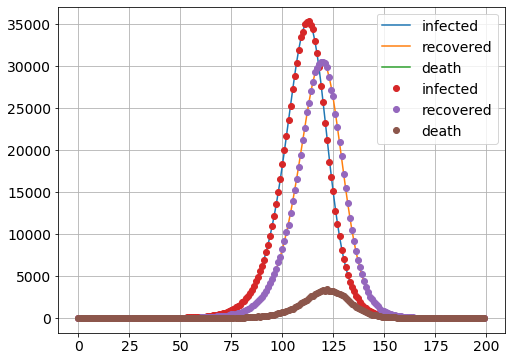

In [10]:
DS = DI0, DR, DM
ds = us.useir_rvdata(DI0, DR, DM)
us.plt_useir_rvdata(ts, DS, ds);

## Some extra checks

$$
\Delta E(t) = - \Delta S() \\
\Delta I_0(t) =  \Delta \tilde{I}(t) = \beta(t) \; \Delta E(t) \circ \rho(t - t'| t_i) \\
\beta(t)      = (R_0/T_R) \, S(t)/N  \\
\Delta I_0(t) / \Delta \tilde{I}(t) \sim \beta(t + T_R)
$$

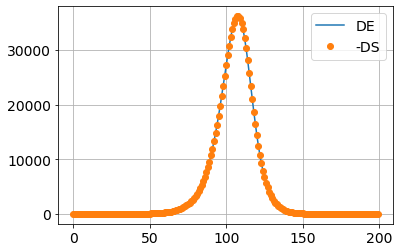

In [11]:
des    = -us.mdeltas(S); des[0] = 0.
#des   = (R0/TR) * (1 - S/N) * I
plt.plot(ts,  DE, label = 'DE' )
plt.plot(ts,  des, ls = '', marker = 'o', label = '-DS')
plt.legend(); plt.grid()
#rhoi = us.fpois(TI)
#Is = [us.uV(FI[:i+1], ts[:i+1], rhoi) for i in range(len(ts))]

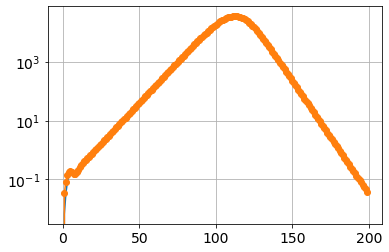

In [12]:
rhoi   = us.fpois(TI)
xdios  = npa([us.uV(DE[:i], ts[:i], rhoi) for i in range(len(ts))])

plt.plot(ts, xdios)
plt.plot(ts, DI0, marker = 'o'); plt.yscale('log'); plt.grid();

0.42857142857142855


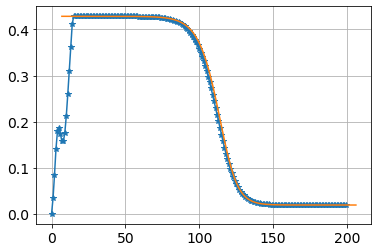

In [13]:
xdios  = npa([us.uV(I[:i], ts[:i], rhoi) for i in range(len(ts))])
betas = DI0/np.maximum(xdios, 1.)
plt.plot(ts, betas, marker = '*')
plt.plot(TR + ts, (R0/TR) * S/N)
plt.grid(); #plt.yscale('log');
print(R0/TR)

### Generate RV data

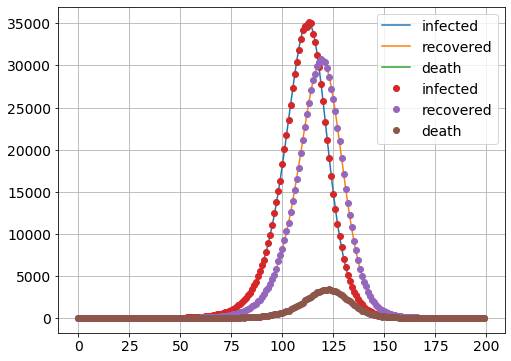

In [14]:
ds = us.useir_rvdata(DI0, DR, DM)
dios, drs, dms = ds
us.plt_useir_rvdata(ts, DS, ds);

## KF

$$
\Delta I (t) = r (t)\; I(t') \circ \rho_i(t-t'| t'_i)   \\
\Delta R (t) = \phi_r \; \Delta I(t') \circ \rho_r(t-t' | t_r) \\
\Delta M (t) = \phi_m \; \Delta I(t') \circ \rho_m(t-t' | t_m) \\
$$

The state 
$$
(r(t), \phi_r, \phi_m)
$$
The measurement
$$
(\Delta i, \Delta r, \Delta m)
$$

The $H$-matrix


$$
H_{i} = \begin{pmatrix} I(t') \circ \rho_i(t-t'| t'_i)  & 0  &   0 \\
0  &  \Delta I(t') \circ \rho_r(t - t' | t_r)  &   0 \\
0  &  0 &  \Delta I(t') \circ \rho_m(t-t' | t_m)
\end{pmatrix}
$$






### Measuremts

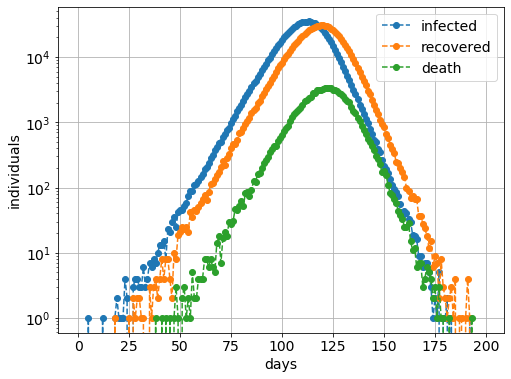

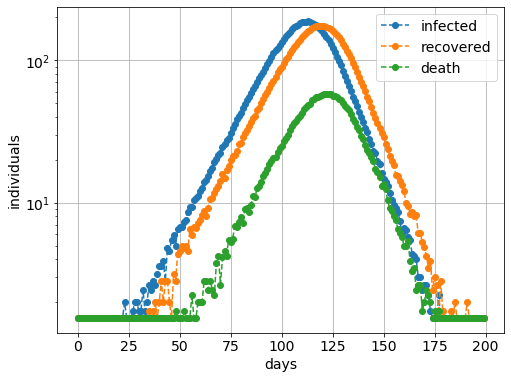

In [15]:
ms, ums      = us.meas(dios, drs, dms)
us.plt_meas(ts, ms, ums)

### Check nis 

$$
\beta(t) = (R_0/T_R) S(t) / N
$$

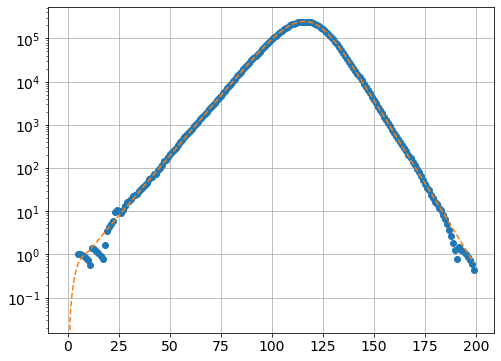

In [16]:
frho = us.fpois
nis, _  = us.nis_(ts, dios, frho(TR), frho(TM), PhiM)
plt.figure(figsize = (8, 6))
plt.plot(ts, nis, marker = 'o', ls = '');
plt.plot(ts, I, ls = '--');
plt.grid(); plt.yscale('log');

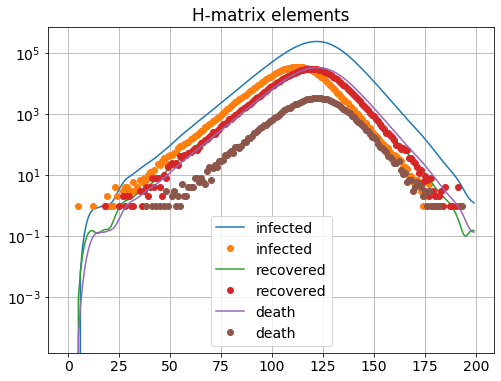

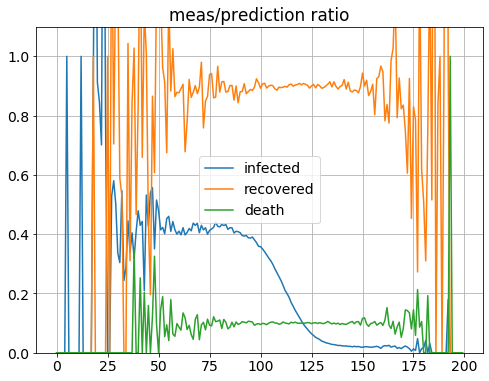

In [29]:
hs   = us.hmatrices(ts, dios, nis, frho(TI), frho(TR), frho(TM))
us.plt_hmatrices2(ts, hs, ms);
plt.ylim((0., 1.1));

[0.47941172 0.86544446 0.06106856] [0.35802395 0.89224977 0.09521412] [0.01875788 0.93921788 0.11592786]


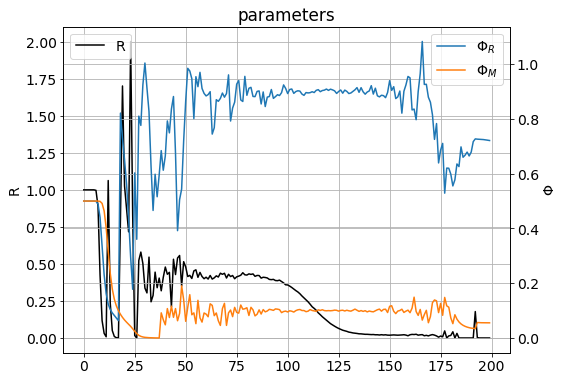

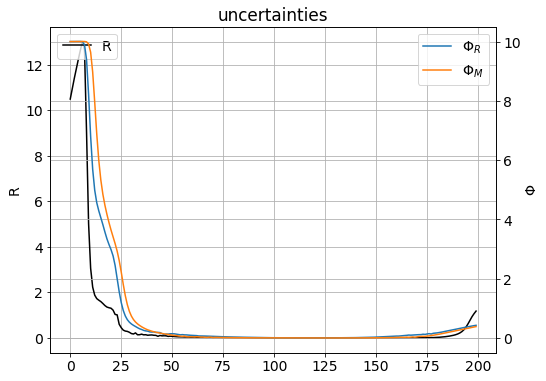

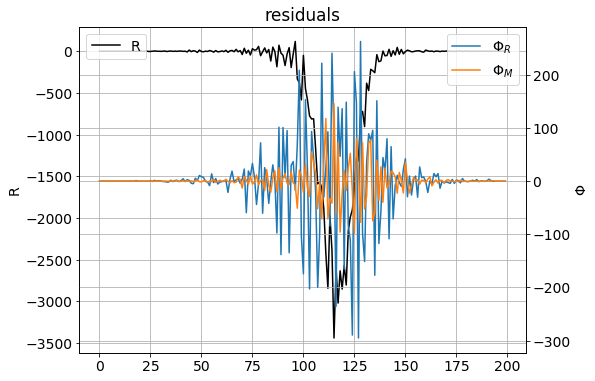

In [30]:
ms, ums      = us.meas(dios, drs, dms)
x0           = npa((1., 0.5, 0.5))
ux0          = np.identity(3) * 100
qi           = npa((10., 0.01, 0.01))
xs, uxs, res = us.useir_kf(ms, ums, hs, x0, ux0, qi)
us.plt_useir_kf(ts, xs, uxs, res)
print(xs[50], xs[100], xs[150])

### Check betas from KF

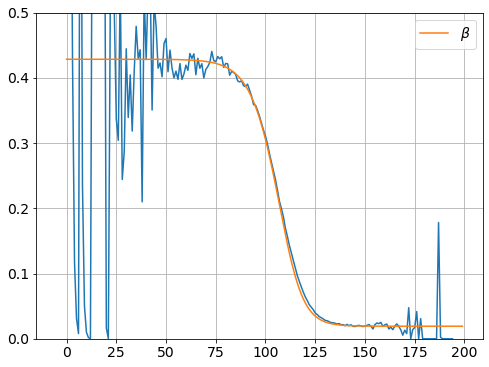

In [31]:
rs = [xi[0] for xi in xs]
plt.figure(figsize = (8, 6))
plt.plot(ts - TI, rs);
plt.plot(ts, (R0/TR) * S/N, label = r'$\beta$');
plt.grid(); plt.legend(); plt.ylim(0., 0.5);

### Move DR->DIOS

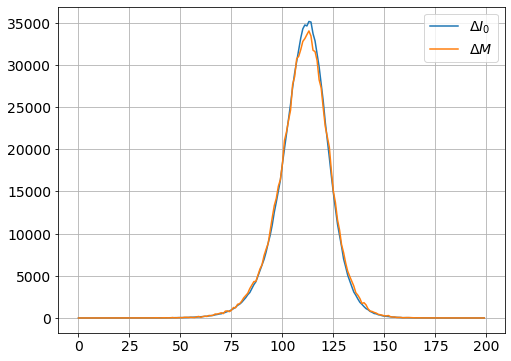

In [32]:
xdios        = np.zeros(len(dios))
i0 = int(TM)
xdios[:-i0]   = dms[i0:]/PhiM
plt.figure(figsize = (8, 6))
plt.plot(ts, dios , label = r'$\Delta I_0$')
plt.plot(ts, xdios, label = r'$\Delta M$');
plt.grid(); plt.legend(); #plt.yscale('log');

[0.42615677 0.86544446 0.06106856] [0.35767118 0.89224977 0.09521412] [0.02171051 0.93921788 0.11592786]


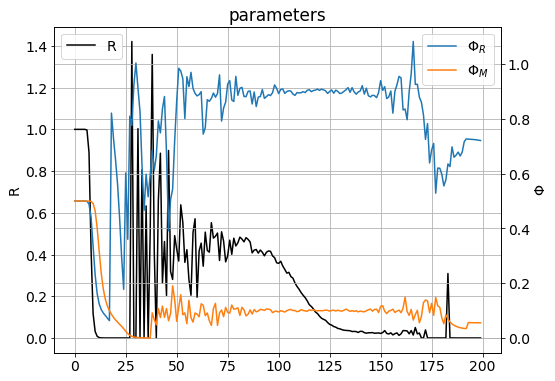

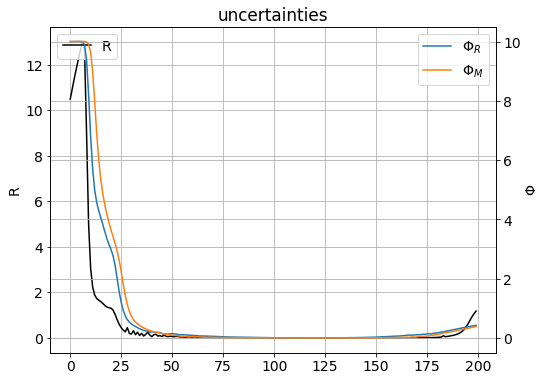

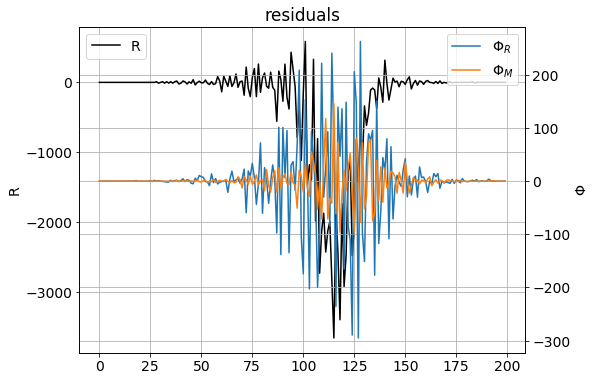

In [33]:
ms, ums      = us.meas(xdios, drs, dms)
x0           = npa((1., 0.5, 0.5))
ux0          = np.identity(3) * 100
qi           = npa((10., 0.01, 0.01))
xs, uxs, res = us.useir_kf(ms, ums, hs, x0, ux0, qi)
us.plt_useir_kf(ts, xs, uxs, res)
print(xs[50], xs[100], xs[150])

### Check Beta

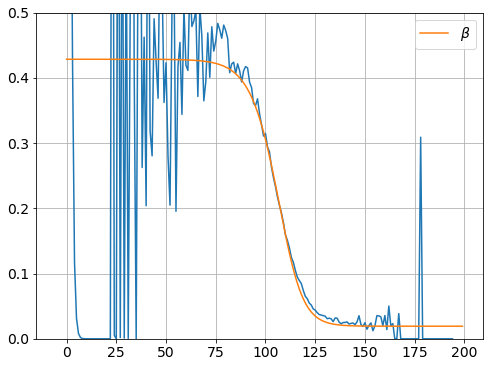

In [34]:
rs = [xi[0] for xi in xs]
plt.figure(figsize = (8, 6))
plt.plot(ts - TI, rs);
plt.plot(ts, (R0/TR) * S/N, label = r'$\beta$');
plt.grid(); plt.legend(); plt.ylim(0., 0.5);

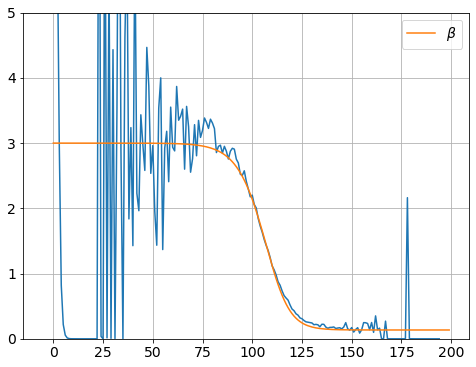

In [37]:
rs = npa([xi[0] for xi in xs])
plt.figure(figsize = (8, 6))
plt.plot(ts - TI, TR * rs);
plt.plot(ts, R0 * S/N, label = r'$\beta$');
plt.grid(); plt.legend(); plt.ylim(0., 5.);